<h1> Setup 1c </h1>

In [1]:
#make imports

import os
import sys
import torch
import numpy as np
import pandas as pd

In [2]:
#load the sentence transformer model and cosine sim loss function

from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer, InputExample, losses, SentencesDataset
from torch.utils.data import DataLoader, Dataset

In [3]:
#load the csv files for train and val

train_df = pd.read_csv('../data/train.csv', sep='\t', on_bad_lines='skip')
dev_df = pd.read_csv('../data/dev.csv', sep='\t', on_bad_lines='skip')

train_df = train_df.dropna()
dev_df = dev_df.dropna()

train_sentence1 = train_df['sentence1'].tolist()
train_sentence2 = train_df['sentence2'].tolist()
train_scores = train_df['score'].tolist()

val_sentence1 = dev_df['sentence1'].tolist()
val_sentence2 = dev_df['sentence2'].tolist()
val_scores = dev_df['score'].tolist()

#scale the train scores b/w 0 and 1
scaled_train_scores = [float(train_score/5.0) for train_score in train_scores]
scaled_val_scores = [float(val_score/5.0) for val_score in val_scores]

In [4]:
#set device as gpu
device = "mps"

#load model
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

In [5]:
train_examples = [
    InputExample(texts=(sentence1, sentence2), label=score) for sentence1, sentence2, score in zip(train_sentence1, train_sentence2, scaled_train_scores)
]

val_examples = [
    InputExample(texts=(sentence1, sentence2), label=score) for sentence1, sentence2, score in zip(val_sentence1, val_sentence2, scaled_val_scores)
]

In [6]:
train_batch_size = 1
train_dataloader = DataLoader(train_examples, shuffle=False, batch_size=train_batch_size)
train_loss = losses.CosineSimilarityLoss(model=model)

In [7]:
#run 1st iteration

model.fit(
    [(train_dataloader, train_loss)],
    epochs=1,
)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5708 [00:00<?, ?it/s]

In [8]:
#import cosine similarity function
from torch.nn import CosineSimilarity
cos = CosineSimilarity(dim=0, eps=1e-4)

#init train loss function
train_losses = []

train_loss = 0
for sentence1,sentence2,gold_score in zip(train_sentence1, train_sentence2, train_scores):
    embedding1 = torch.tensor(model.encode(sentence1)).to(device)
    embedding2 = torch.tensor(model.encode(sentence2)).to(device)

    #calculate cosine similarity and loss after scaling
    tmp_loss = cos(embedding1, embedding2)*5
    train_loss += (gold_score-tmp_loss)*(gold_score-tmp_loss)

train_losses.append(train_loss)
print(train_loss)

tensor(2781.8494, device='mps:0')


In [9]:
val_losses = []

val_loss = 0
for sentence1,sentence2,gold_score in zip(val_sentence1, val_sentence2, val_scores):
    embedding1 = torch.tensor(model.encode(sentence1)).to(device)
    embedding2 = torch.tensor(model.encode(sentence2)).to(device)

    #calculate cosine similarity and loss after scaling
    tmp_loss = cos(embedding1, embedding2)*5
    val_loss += (gold_score-tmp_loss)*(gold_score-tmp_loss)

val_losses.append(val_loss)
print(val_loss)

tensor(839.8903, device='mps:0')


In [11]:
#run 2nd iteration

train_batch_size = 1
train_dataloader = DataLoader(train_examples, shuffle=False, batch_size=train_batch_size)
train_loss = losses.CosineSimilarityLoss(model=model)

model.fit(
    [(train_dataloader, train_loss)],
    epochs=1,
)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5708 [00:00<?, ?it/s]

In [12]:
#calculate train loss

train_loss = 0
for sentence1,sentence2,gold_score in zip(train_sentence1, train_sentence2, train_scores):
    embedding1 = torch.tensor(model.encode(sentence1)).to(device)
    embedding2 = torch.tensor(model.encode(sentence2)).to(device)

    #calculate cosine similarity and loss after scaling
    tmp_loss = cos(embedding1, embedding2)*5
    train_loss += (gold_score-tmp_loss)*(gold_score-tmp_loss)

train_losses.append(train_loss)
print(train_loss)

tensor(1978.0156, device='mps:0')


In [13]:
#calculate val loss

val_loss = 0
for sentence1,sentence2,gold_score in zip(val_sentence1, val_sentence2, val_scores):
    embedding1 = torch.tensor(model.encode(sentence1)).to(device)
    embedding2 = torch.tensor(model.encode(sentence2)).to(device)

    #calculate cosine similarity and loss after scaling
    tmp_loss = cos(embedding1, embedding2)*5
    val_loss += (gold_score-tmp_loss)*(gold_score-tmp_loss)

val_losses.append(val_loss)
print(val_loss)

tensor(769.3137, device='mps:0')


In [14]:
print(train_losses)
print(val_losses)

[tensor(2781.8494, device='mps:0'), tensor(1978.0156, device='mps:0')]
[tensor(839.8903, device='mps:0'), tensor(769.3137, device='mps:0')]


In [15]:
#store dev similarity scores

dev_similarity_scores = []

for sentence1,sentence2 in zip(val_sentence1, val_sentence2):
    embedding1 = torch.tensor(model.encode(sentence1)).to(device)
    embedding2 = torch.tensor(model.encode(sentence2)).to(device)

    #calculate cosine similarity
    similarity_score = cos(embedding1, embedding2)*5
    dev_similarity_scores.append(similarity_score)

In [17]:
dev_similarity_scores = [float(score) for score in dev_similarity_scores]

In [19]:
#calculate pearson correlation
from scipy.stats import pearsonr

pearson_corr = pearsonr(val_scores, dev_similarity_scores)
print(pearson_corr)

PearsonRResult(statistic=0.8864435579567016, pvalue=0.0)


In [20]:
#save the model

model.save('setup1c')

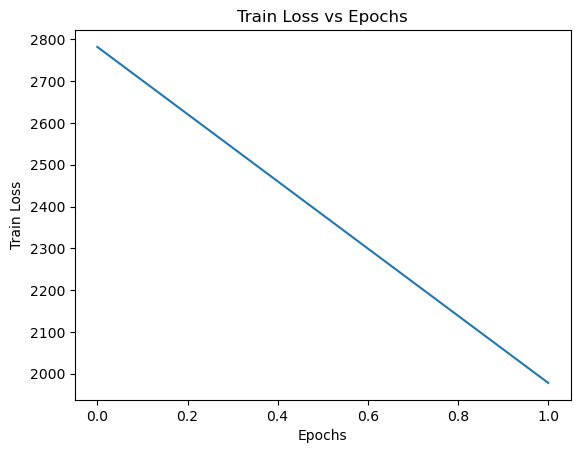

In [23]:
#plot train loss against number of epochs
import matplotlib.pyplot as plt

train_losses = [float(loss) for loss in train_losses]
plt.plot(train_losses)
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.title('Train Loss vs Epochs')
plt.show()

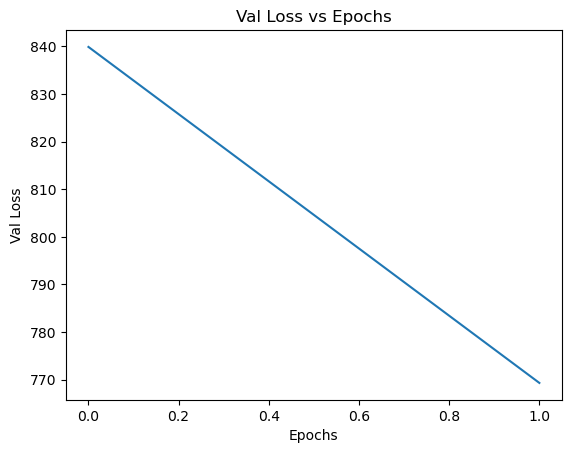

In [24]:
#plot val loss against number of epochs

val_losses = [float(loss) for loss in val_losses]
plt.plot(val_losses)
plt.xlabel('Epochs')
plt.ylabel('Val Loss')
plt.title('Val Loss vs Epochs')
plt.show()